# Applied Data Science Capstone Project
Using historical data to analyse and estimate road accident severity.

In [4]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline

In [5]:
filename = 'Data-Collisions.csv'
collisions_loaded = pd.read_csv(filename)
collisions_loaded.head()

C:\Anaconda\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [6]:
collisions_loaded.rename(columns={'SEVERITYCODE': 'severity'}, inplace=True)
collisions_loaded.columns

Index(['severity', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

### Copy loaded data for convenience

In [7]:
collisions_df = collisions_loaded.copy()
collisions_df.shape

(194673, 38)

## Clean Data

In [8]:
print('Loaded data dimensions (shape)', collisions_df.shape)
collisions_df.dtypes

Loaded data dimensions (shape) (194673, 38)


severity            int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

### Item: SEVERITYCODE
This code corresponds to the severity of the collision. Only two codes are represented in the data ***(1=property damage and 2=injury)***. This code can be used as the target labels for the purpose of machine learning (ML). The redundundant SEVERITYCODE.1 should be dropped.
<p/>

### Item: X, Y
These are coordinates, ***where X=longitude (magnitudes<180) and Y=latitude (magnitudes<90)*** - these can be renamed used instead of the **LOCATION**, which is a description of the general location of the collision. So LOCATION should be dropped.
<p/>

### Initial List of Reduncant Items: (***based on insights drawn from the metadata document***)
OBJECTID, INCKEY, COLDETKEY, REPORTNO, INTKEY, EXCEPTRSNCODE, EXCEPTRSNDESC, SEVERITYDESC (***deferred***), INCDATE (***prefer INCDTTM***), SDOT_COLDESC, ST_COLDESC

In [9]:
colns_to_drop = ['SEVERITYCODE.1', 'LOCATION', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'INTKEY', 'EXCEPTRSNCODE',\
                 'EXCEPTRSNDESC', 'SEVERITYDESC', 'INCDATE', 'SDOT_COLDESC', 'ST_COLDESC']
collisions_df.drop(columns=colns_to_drop, inplace=True)

In [10]:
collisions_df.rename(columns={'X': 'longitude', 'Y': 'latitude'}, inplace=True)
collisions_df

,severity,longitude,latitude,STATUS,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,...,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,Matched,Intersection,Angles,2,0,0,2,...,Overcast,Wet,Daylight,NaN,NaN,NaN,10,0,0,N
1,1,-122.347294,47.647172,Matched,Block,Sideswipe,2,0,0,2,...,Raining,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,0,0,N
2,1,-122.334540,47.607871,Matched,Block,Parked Car,4,0,0,3,...,Overcast,Dry,Daylight,NaN,4323031.0,NaN,32,0,0,N
3,1,-122.334803,47.604803,Matched,Block,Other,3,0,0,3,...,Clear,Dry,Daylight,NaN,NaN,NaN,23,0,0,N
4,2,-122.306426,47.545739,Matched,Intersection,Angles,2,0,0,2,...,Raining,Wet,Daylight,NaN,4028032.0,NaN,10,0,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,2,-122.290826,47.565408,Matched,Block,Head On,3,0,0,2,...,Clear,Dry,Daylight,NaN,NaN,NaN,24,0,0,N
194669,1,-122.344526,47.690924,Matched,Block,Rear Ended,2,0,0,2,...,Raining,Wet,Daylight,NaN,NaN,NaN,13,0,0,N
194670,2,-122.306689,47.683047,Matched,Intersection,Left Turn,3,0,0,2,...,Clear,Dry,Daylight,NaN,NaN,NaN,28,0,0,N
194671,2,-122.355317,47.678734,Matched,Intersection,Cycles,2,0,1,1,...,Clear,Dry,Dusk,NaN,NaN,NaN,5,4308,0,N


# Business Understanding
The objective is to leverage the accident data set provided to predict the different accidents' severity (the target label). The data set provides only two classes of severity (property damage=1, injury=2) as indicated by the SEVERITYCODE column. This is therefore, a binary classification problem.<p/>
Clearly, there are implications for predicting the severity class of each collision (either injury or property damage). The assumption is that an injury from a collision will indicate that the any medical assistance team will need to come prepared to possibly safe lifes or at least improve the chances of survival. The emergency team must come prepared to improve survival rates - and they may need to ask preparatory questions in preparation as they approach the collision location, etc. Therefore, false negatives (for the injury class) could have major implications. A false positive simply means that the emergency team would come prepared for injury that in all likelihood does did not actually occur - the cost implications for this scenary presumably are much lower and can be considered manageable.<p/>
On the other hand, the issue of property damage may not have such life-threatening implications compared to collision injury.

### Revisit the column data types

In [11]:
collisions_df.dtypes

severity            int64
longitude         float64
latitude          float64
STATUS             object
ADDRTYPE           object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: object

<hr color= "red"/> 

### Data Visualization and Pre-processing
Based on the target labels, let’s see how many of each class are in the data set (is it balanced or unbalanced)

In [12]:
collisions_df['severity'].value_counts()

1    136485
2     58188
Name: severity, dtype: int64

**Summary:**<br/>
    136485 collisions are property damage (1) and 58188 (injury) ==> the class distribution is unbalanced. ***The classifier performance will be better evaluated with the F1-Score metric instead of accuracy, as it is the harmonic mean of the recall and precision***.<p/>
    According to the following article, <a href="https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2">Accuracy vs. F1-Score</a> by Purva Huilgol, there are critical differences between accuracy and F1-Score:<br/>
    -- Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial<br/>
    -- Accuracy can be used when the class distribution is similar while F1-score is a better metric when there are imbalanced classes as in the above case<br/>
    -- In most real-life classification problems, imbalanced class distribution exists and thus F1-score is a better metric to evaluate our model on<br/>

Plot some columns to get a better understanding of the data set:

### Convert to date time object 

In [13]:
collisions_df['INCDTTM'] = pd.to_datetime(collisions_df['INCDTTM'])
collisions_df['INCDTTM'].head()

0   2013-03-27 14:54:00
1   2006-12-20 18:55:00
2   2004-11-18 10:20:00
3   2013-03-29 09:26:00
4   2004-01-28 08:04:00
Name: INCDTTM, dtype: datetime64[ns]

### Lets look at the hour of the day that collisions occur

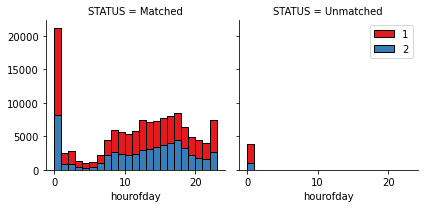

In [14]:
collisions_df['hourofday'] = collisions_df['INCDTTM'].dt.hour
bins = np.linspace(collisions_df.hourofday.min(), collisions_df.hourofday.max(), 24)
g = sns.FacetGrid(collisions_df, col="STATUS", hue="severity", palette="Set1", col_wrap=2)
g.map(plt.hist, 'hourofday', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

It appears that there is an unusual volume of collisions in the first hour of the day. So we can use feature binarization to set a threshold value less than hour 12 or morning hours. But more generally, the collisions and injuries increase during the day through the afternoon - so it depends on the time of the day.

In [15]:
morning_threshold = 12
collisions_df['morning'] = collisions_df['hourofday'].apply(lambda x: 1 if (x>morning_threshold)  else 0)
collisions_df[['INCDTTM', 'hourofday', 'morning']].head()

,INCDTTM,hourofday,morning
0,2013-03-27 14:54:00,14,1
1,2006-12-20 18:55:00,18,1
2,2004-11-18 10:20:00,10,0
3,2013-03-29 09:26:00,9,0
4,2004-01-28 08:04:00,8,0


<hr color= "red"/> 

## Convert Categorical features to numerical values

Lets look at collision status:
*Matched possibly refers to matched pairs or collisions involving two vehicles, see this study in the <a href="https://academic.oup.com/aje/article/167/5/546/211795">American Journal of Epidemiology</a>.*

In [16]:
collisions_df.groupby(['STATUS'])['severity'].value_counts(normalize=True)

STATUS     severity
Matched    1           0.698824
           2           0.301176
Unmatched  1           0.789441
           2           0.210559
Name: severity, dtype: float64

30% of matched collisions result in injury compared to 21% of unmatched collisions - not a huge difference but significant

Lets convert matched to 0 and unmatched to 1:

In [17]:
collisions_df['STATUS'].replace(to_replace=['Matched','Unmatched'], value=[0, 1],inplace=True)

Lets look at inattention: *(reasonable default seems to be 'N')*

In [18]:
# first replace all missing data with 'N' - seems a reasonable default
collisions_df['INATTENTIONIND'].fillna('N', inplace=True)
collisions_df['INATTENTIONIND'].replace(to_replace=['N','Y'], value=[0, 1],inplace=True)

In [19]:
collisions_df.groupby(['INATTENTIONIND'])['severity'].value_counts(normalize=True)

INATTENTIONIND  severity
0               1           0.710126
                2           0.289874
1               1           0.651166
                2           0.348834
Name: severity, dtype: float64

In 35% of collisions inattention = Y result in injury, compared to 29% where inattention = N.<br/>

Lets look at under the influence: *(0=N, 1=Y)*

In [20]:
# first replace all missing data with 'N' or 0 - seems a reasonable default
collisions_df['UNDERINFL'].fillna('N', inplace=True)
collisions_df['UNDERINFL'].replace(to_replace=['0', '1','N','Y'], value=[0, 1, 0, 1],inplace=True)
collisions_df['UNDERINFL'] = collisions_df['UNDERINFL'].astype(int)

In [21]:
collisions_df.groupby(['UNDERINFL'])['severity'].value_counts(normalize=True)

UNDERINFL  severity
0          1           0.705603
           2           0.294397
1          1           0.609473
           2           0.390527
Name: severity, dtype: float64

In 39% of collisions with driver under the influence resulted in injury, compared to 29% with driver not under the influence.<br/>

Lets look at speeding: *(0=N, 1=Y)*

In [22]:
# first replace all missing data with 'N' or 0 - seems a reasonable default
collisions_df['SPEEDING'].fillna('N', inplace=True)
collisions_df['SPEEDING'].replace(to_replace=['N','Y'], value=[0, 1],inplace=True)
collisions_df['SPEEDING'] = collisions_df['SPEEDING'].astype(int)

In [23]:
collisions_df.groupby(['SPEEDING'])['severity'].value_counts(normalize=True)

SPEEDING  severity
0         1           0.705099
          2           0.294901
1         1           0.621665
          2           0.378335
Name: severity, dtype: float64

In 38% of collisions with driver speeding resulted in injury, compared to 29% with driver not speeding.<br/>

<hr color= "red"/> 

At this point, check the status of the dataframe:

In [24]:
collisions_df.head()

,severity,longitude,latitude,STATUS,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,...,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,hourofday,morning
0,2,-122.323148,47.703140,0,Intersection,Angles,2,0,0,2,...,Daylight,NaN,NaN,0,10,0,0,N,14,1
1,1,-122.347294,47.647172,0,Block,Sideswipe,2,0,0,2,...,Dark - Street Lights On,NaN,6354039.0,0,11,0,0,N,18,1
2,1,-122.334540,47.607871,0,Block,Parked Car,4,0,0,3,...,Daylight,NaN,4323031.0,0,32,0,0,N,10,0
3,1,-122.334803,47.604803,0,Block,Other,3,0,0,3,...,Daylight,NaN,NaN,0,23,0,0,N,9,0
4,2,-122.306426,47.545739,0,Intersection,Angles,2,0,0,2,...,Daylight,NaN,4028032.0,0,10,0,0,N,8,0


<hr color= "red"/> 

## One Hot Encoding  
#### Lets start with collision type

In [25]:
# make sure all NaN are converted to 'Other'
collisions_df['COLLISIONTYPE'].fillna('Other', inplace=True)
np.array(set(collisions_df['COLLISIONTYPE'].values))

array({'Sideswipe', 'Right Turn', 'Rear Ended', 'Parked Car', 'Pedestrian', 'Other', 'Angles', 'Cycles', 'Left Turn', 'Head On'},
      dtype=object)

In [26]:
collisions_df.groupby(['COLLISIONTYPE'])['severity'].value_counts(normalize=False)
#collisions_df.groupby(['COLLISIONTYPE'])['SEVERITYCODE'].value_counts(normalize=True)

COLLISIONTYPE  severity
Angles         1           21050
               2           13624
Cycles         2            4744
               1             671
Head On        1            1152
               2             872
Left Turn      1            8292
               2            5411
Other          1           21454
               2            7153
Parked Car     1           45325
               2            2662
Pedestrian     2            5936
               1             672
Rear Ended     1           19419
               2           14671
Right Turn     1            2347
               2             609
Sideswipe      1           16103
               2            2506
Name: severity, dtype: int64

Lets look at the weather:

In [27]:
# make sure all NaN are converted to 'Other'
collisions_df['WEATHER'].fillna('Other', inplace=True)
np.array(set(collisions_df['WEATHER'].values))

array({'Severe Crosswind', 'Snowing', 'Blowing Sand/Dirt', 'Overcast', 'Other', 'Fog/Smog/Smoke', 'Partly Cloudy', 'Clear', 'Unknown', 'Sleet/Hail/Freezing Rain', 'Raining'},
      dtype=object)

In [28]:
collisions_df.groupby(['WEATHER'])['severity'].value_counts(normalize=False)

WEATHER                   severity
Blowing Sand/Dirt         1              41
                          2              15
Clear                     1           75295
                          2           35840
Fog/Smog/Smoke            1             382
                          2             187
Other                     1            4713
                          2            1200
Overcast                  1           18969
                          2            8745
Partly Cloudy             2               3
                          1               2
Raining                   1           21969
                          2           11176
Severe Crosswind          1              18
                          2               7
Sleet/Hail/Freezing Rain  1              85
                          2              28
Snowing                   1             736
                          2             171
Unknown                   1           14275
                          2             8

Lets look at road conditions:

In [29]:
# make sure all NaN are converted to 'Other'
collisions_df['ROADCOND'].fillna('Other', inplace=True)
np.array(set(collisions_df['ROADCOND'].values))

array({'Ice', 'Dry', 'Standing Water', 'Other', 'Oil', 'Snow/Slush', 'Unknown', 'Wet', 'Sand/Mud/Dirt'},
      dtype=object)

In [30]:
collisions_df.groupby(['ROADCOND'])['severity'].value_counts(normalize=False)

ROADCOND        severity
Dry             1           84446
                2           40064
Ice             1             936
                2             273
Oil             1              40
                2              24
Other           1            4041
                2            1103
Sand/Mud/Dirt   1              52
                2              23
Snow/Slush      1             837
                2             167
Standing Water  1              85
                2              30
Unknown         1           14329
                2             749
Wet             1           31719
                2           15755
Name: severity, dtype: int64

Lets look at light conditions:

In [31]:
# make sure all NaN are converted to 'Other'
collisions_df['LIGHTCOND'].fillna('Other', inplace=True)
np.array(set(collisions_df['LIGHTCOND'].values))

array({'Dark - No Street Lights', 'Dark - Street Lights Off', 'Dark - Street Lights On', 'Dawn', 'Other', 'Dusk', 'Unknown', 'Daylight', 'Dark - Unknown Lighting'},
      dtype=object)

In [32]:
collisions_df.groupby(['LIGHTCOND'])['severity'].value_counts(normalize=False)

LIGHTCOND                 severity
Dark - No Street Lights   1            1203
                          2             334
Dark - Street Lights Off  1             883
                          2             316
Dark - Street Lights On   1           34032
                          2           14475
Dark - Unknown Lighting   1               7
                          2               4
Dawn                      1            1678
                          2             824
Daylight                  1           77593
                          2           38544
Dusk                      1            3958
                          2            1944
Other                     1            4263
                          2            1142
Unknown                   1           12868
                          2             605
Name: severity, dtype: int64

<hr color= "red"/> 

# Combining Latitude/Longitude
Combining latitude/longitude position into single feature using the <a href="https://datascience.stackexchange.com/questions/49553/combining-latitude-longitude-position-into-single-feature">Haversine formula</a>

In [33]:
from math import radians, cos, sin, asin, sqrt

def location(lat, lng, degrees=True):
    """
    'Single-point' Haversine: Calculates the great circle distance
    between a point on Earth and the (0, 0) lat-long coordinate
    """
    r = 6371 # Earth's radius (km). Have r = 3956 if you want miles

    # Convert decimal degrees to radians
    if degrees:
        lat, lng = map(radians, [lat, lng])

    # 'Single-point' Haversine formula
    a = sin(lat/2)**2 + cos(lat) * sin(lng/2)**2
    d = 2 * r * asin(sqrt(a)) 

    return d

Use the location function defined to calculate a single location for each pair of latitude/longitude:

In [34]:
collisions_df['location'] = [location(x, y) for x, y in zip(collisions_df.latitude, collisions_df.longitude)]
collisions_df['location'].head()

0    12352.644223
1    12356.919651
2    12357.905534
3    12358.067920
4    12358.918252
Name: location, dtype: float64

Lets look at the locations that collisions occur:

Bins:  [12348.67136849 12350.64503458 12352.61870067 12354.59236676
 12356.56603286 12358.53969895 12360.51336504 12362.48703113
 12364.46069722 12366.43436331]


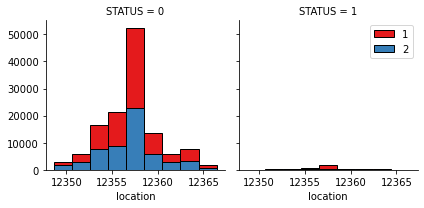

In [35]:
bins = np.linspace(collisions_df.location.min(), collisions_df.location.max(), 10)
print('Bins: ', bins)
g = sns.FacetGrid(collisions_df, col="STATUS", hue="severity", palette="Set1", col_wrap=2)
g.map(plt.hist, 'location', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

**Summary:** It seems that most of the collisions occure within approximately one standard deviation from a mean point (hot spot).<br/>
We can use feature binarization to set a threshold value about one standard deviation from the hot spot (mean). The bins could be representative of location brackets or locality.

#### First, explore the location partitions or bins or localities:

In [36]:
collisions_df['locality'] = collisions_df['location'].apply(lambda x: np.digitize(x, bins))
collisions_df['locality'].head()

0    3
1    5
2    5
3    5
4    6
Name: locality, dtype: int64

#### Then explore idea of the hot spot as well:

In [37]:
hot_spot = collisions_df.location.mean()
loc_std = collisions_df.location.std()
print('The hot spot is estimated at location [mean =', hot_spot, ',std =', loc_std,']')

The hot spot is estimated at location [mean = 12357.08123630904 ,std = 3.0681291833829416 ]


In [38]:
# binarize location --> point is either within the standard deviation window or not
thres_mult = 1 # i.e. thres_mult * standard deviations from the hot spot
lower_bound = hot_spot - thres_mult*loc_std
upper_bound = hot_spot + thres_mult*loc_std
collisions_df['location'] = collisions_df['location'].apply(lambda x: 1 if (x>lower_bound and x<upper_bound) else 0)
#collisions_df['location'].head()

<hr color= "red"/> 

Lets look at the total number of people involved in collision (PERSONCOUNT):

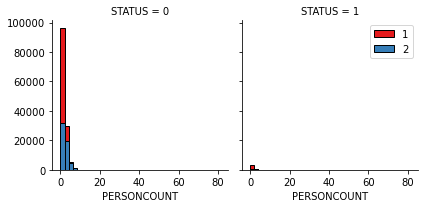

In [39]:
bins = np.linspace(collisions_df.PERSONCOUNT.min(), collisions_df.PERSONCOUNT.max(), 40)
#print('Bins: ', bins)
g = sns.FacetGrid(collisions_df, col="STATUS", hue="severity", palette="Set1", col_wrap=2)
g.map(plt.hist, 'PERSONCOUNT', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

**Summary:** It seems that most of the collisions involving <10 people are associated with most injuries occur.<br/>
We can use feature binarization to set a threshold value of 10.

In [40]:
count_threshold = 10
collisions_df['PERSONCOUNT'] = collisions_df['PERSONCOUNT'].apply(lambda x: x if (x<count_threshold)  else 0)
#collisions_df[['PERSONCOUNT']].head()

In [41]:
collisions_df.groupby(['PERSONCOUNT'])['severity'].value_counts(normalize=False)

PERSONCOUNT  severity
0            1            3960
             2            1949
1            1            9858
             2            3296
2            1           86420
             2           27811
3            1           22092
             2           13461
4            1            8365
             2            6295
5            1            3615
             2            2969
6            2            1357
             1            1345
7            2             637
             1             494
8            2             284
             1             249
9            2             129
             1              87
Name: severity, dtype: int64

In 27% of collisions with <4 people resulted in injury, compared to 45% with 4 or more people.<br/>

Lets look at the total number of pedestrians involved in collision (PEDCOUNT):

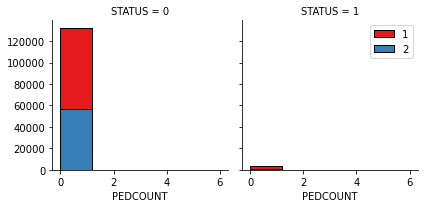

In [42]:
bins = np.linspace(collisions_df.PEDCOUNT.min(), collisions_df.PEDCOUNT.max(), 6)
#print('Bins: ', bins)
g = sns.FacetGrid(collisions_df, col="STATUS", hue="severity", palette="Set1", col_wrap=2)
g.map(plt.hist, 'PEDCOUNT', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

**Summary:** It seems that most of the collisions with <2 pedestrians is where most injuries occur.<br/>
We can use feature binarization to set a threshold value of 2. We must ignore all those with zero pedestrians.

In [43]:
count_threshold = 2
# ignore all with zero pedestrians
collisions_df['PEDCOUNT'] = collisions_df['PEDCOUNT'].apply(lambda x: 1 if (x<count_threshold and x>0)  else 0)
#collisions_df[['PEDCOUNT']].tail(20)

In [44]:
collisions_df.groupby(['PEDCOUNT'])['severity'].value_counts(normalize=False)

PEDCOUNT  severity
0         1           135807
          2            52181
1         2             6007
          1              678
Name: severity, dtype: int64

In 10% of collisions involving pedestrians resulted in injury, compared to 27% without.<br/>

Lets look at the total number of bicycles involved in collision (PEDCYLCOUNT):

In [45]:
# either a bicycle was involved or not
collisions_df['PEDCYLCOUNT'] = collisions_df['PEDCYLCOUNT'].apply(lambda x: 1 if (x>0)  else 0)

Lets look at the total number of vehicles involved in collision (VEHCOUNT):

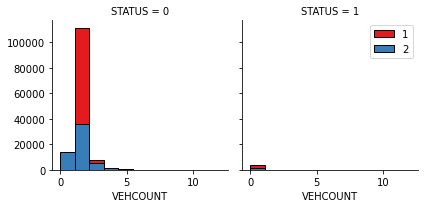

In [46]:
bins = np.linspace(collisions_df.VEHCOUNT.min(), collisions_df.VEHCOUNT.max(), 12)
#print('Bins: ', bins)
g = sns.FacetGrid(collisions_df, col="STATUS", hue="severity", palette="Set1", col_wrap=2)
g.map(plt.hist, 'VEHCOUNT', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [47]:
# either two vehicles were involved or not
collisions_df['VEHCOUNT'] = collisions_df['VEHCOUNT'].apply(lambda x: x if (x < 5)  else 0)

In [48]:
collisions_df.groupby(['VEHCOUNT'])['severity'].value_counts(normalize=False)

VEHCOUNT  severity
0         1             4253
          2             1586
1         2            14105
          1            11643
2         1           111701
          2            35949
3         1             7540
          2             5470
4         1             1348
          2             1078
Name: severity, dtype: int64

The vast majority of collisions involved two vehicles, with 24% of collisions involving 2 vehicles resulting in injury, compared to 47% otherwise.<br/>

Lets look at the state collision code associated with the collision (SDOT_COLCODE):

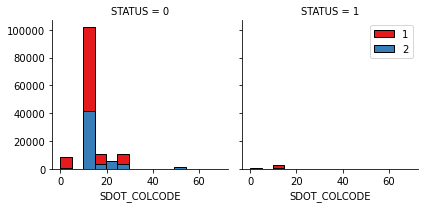

In [49]:
bins = np.linspace(collisions_df.SDOT_COLCODE.min(), collisions_df.SDOT_COLCODE.max(), 15)
#print('Bins: ', bins)
g = sns.FacetGrid(collisions_df, col="STATUS", hue="severity", palette="Set1", col_wrap=2)
g.map(plt.hist, 'SDOT_COLCODE', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

It appears that most collisions are associated with codes between 10 and 15 and most injuries match that range (entering at an angle etc.).

In [50]:
# either two vehicles were involved or not
collisions_df['SDOT_COLCODE'] = collisions_df['SDOT_COLCODE'].apply(lambda x: x if (x >= 10 and x<=30)  else 0)

In [51]:
collisions_df.groupby(['SDOT_COLCODE'])['severity'].value_counts(normalize=False)

SDOT_COLCODE  severity
0             1            9652
              2            2401
11            1           60871
              2           24338
12            1            1413
              2              27
13            1            5653
              2             199
14            1           36551
              2           17748
15            1            1529
              2              75
16            1            9236
              2             692
18            2            2734
              1             370
21            2             140
              1              41
22            2              16
              1               1
23            2              93
              1              31
24            2            5853
              1             665
25            1              82
              2              20
26            1            3568
              2            1173
27            1             130
              2              36
28            1  

*The other related code, SDOTCOLNUM, a number given to the collision by SDOT, appears to provide a reduncdant code and appears to be an over-specification of the same factors address by a variety of other factors already included. This code can reasonably be ignored.*

<hr color= "red"/> 

### Summarize Collisions Data Set Columns

In [52]:
collisions_df.columns

Index(['severity', 'longitude', 'latitude', 'STATUS', 'ADDRTYPE',
       'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'INATTENTIONIND',
       'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT',
       'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'SEGLANEKEY', 'CROSSWALKKEY',
       'HITPARKEDCAR', 'hourofday', 'morning', 'location', 'locality'],
      dtype='object')

## Create features set from the prepared data set

In [53]:
Features = collisions_df[['location','locality', 'STATUS','COLLISIONTYPE','PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', \
                          'hourofday', 'SDOT_COLCODE', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', \
                          'SPEEDING', 'morning']]
Features.head()

,location,locality,STATUS,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,hourofday,SDOT_COLCODE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,morning
0,0,3,0,Angles,2,0,0,2,14,11,0,0,Overcast,Wet,Daylight,0,1
1,1,5,0,Sideswipe,2,0,0,2,18,16,0,0,Raining,Wet,Dark - Street Lights On,0,1
2,1,5,0,Parked Car,4,0,0,3,10,14,0,0,Overcast,Dry,Daylight,0,0
3,1,5,0,Other,3,0,0,3,9,11,0,0,Clear,Dry,Daylight,0,0
4,1,6,0,Angles,2,0,0,2,8,11,0,0,Raining,Wet,Daylight,0,0


#### We use the one hot encoding technique to conver categorical varables, such as collision type, to binary variables and append them to the features Data Frame 

In [54]:
Features = pd.concat([Features, pd.get_dummies(collisions_df[['COLLISIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']])], axis=1)
Features.drop(['COLLISIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND'], axis = 1, inplace=True)
Features.head()

,location,locality,STATUS,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,hourofday,SDOT_COLCODE,INATTENTIONIND,...,ROADCOND_Wet,LIGHTCOND_Dark - No Street Lights,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown
0,0,3,0,2,0,0,2,14,11,0,...,1,0,0,0,0,0,1,0,0,0
1,1,5,0,2,0,0,2,18,16,0,...,1,0,0,1,0,0,0,0,0,0
2,1,5,0,4,0,0,3,10,14,0,...,0,0,0,0,0,0,1,0,0,0
3,1,5,0,3,0,0,3,9,11,0,...,0,0,0,0,0,0,1,0,0,0
4,1,6,0,2,0,0,2,8,11,0,...,1,0,0,0,0,0,1,0,0,0


In [55]:
Features.columns

Index(['location', 'locality', 'STATUS', 'PERSONCOUNT', 'PEDCOUNT',
       'PEDCYLCOUNT', 'VEHCOUNT', 'hourofday', 'SDOT_COLCODE',
       'INATTENTIONIND', 'UNDERINFL', 'SPEEDING', 'morning',
       'COLLISIONTYPE_Angles', 'COLLISIONTYPE_Cycles', 'COLLISIONTYPE_Head On',
       'COLLISIONTYPE_Left Turn', 'COLLISIONTYPE_Other',
       'COLLISIONTYPE_Parked Car', 'COLLISIONTYPE_Pedestrian',
       'COLLISIONTYPE_Rear Ended', 'COLLISIONTYPE_Right Turn',
       'COLLISIONTYPE_Sideswipe', 'WEATHER_Blowing Sand/Dirt', 'WEATHER_Clear',
       'WEATHER_Fog/Smog/Smoke', 'WEATHER_Other', 'WEATHER_Overcast',
       'WEATHER_Partly Cloudy', 'WEATHER_Raining', 'WEATHER_Severe Crosswind',
       'WEATHER_Sleet/Hail/Freezing Rain', 'WEATHER_Snowing',
       'WEATHER_Unknown', 'ROADCOND_Dry', 'ROADCOND_Ice', 'ROADCOND_Oil',
       'ROADCOND_Other', 'ROADCOND_Sand/Mud/Dirt', 'ROADCOND_Snow/Slush',
       'ROADCOND_Standing Water', 'ROADCOND_Unknown', 'ROADCOND_Wet',
       'LIGHTCOND_Dark - No Street L

In [56]:
Features.shape

(194673, 52)

<hr color= "red"/> 

### Classification Features selection

Now, we define the classification feature sets, X:

In [57]:
# remove all the unknown or other conditions as they add very little interpretational or meaningful value
# further refinement based on the earlier analysis done above
full_short_listed = ['location', 'locality', 'STATUS', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'SDOT_COLCODE', \
                     'INATTENTIONIND', 'UNDERINFL', 'SPEEDING', 'morning', 'COLLISIONTYPE_Angles', 'COLLISIONTYPE_Cycles', \
                     'COLLISIONTYPE_Head On', 'COLLISIONTYPE_Left Turn', 'COLLISIONTYPE_Parked Car', 'COLLISIONTYPE_Pedestrian', \
                     'COLLISIONTYPE_Rear Ended', 'COLLISIONTYPE_Right Turn', 'COLLISIONTYPE_Sideswipe', 'WEATHER_Blowing Sand/Dirt', \
                     'WEATHER_Clear', 'WEATHER_Fog/Smog/Smoke', 'WEATHER_Overcast', 'WEATHER_Partly Cloudy', 'WEATHER_Raining', \
                     'WEATHER_Severe Crosswind', 'WEATHER_Sleet/Hail/Freezing Rain', 'WEATHER_Snowing', 'ROADCOND_Dry', 'ROADCOND_Ice', \
                     'ROADCOND_Oil', 'ROADCOND_Sand/Mud/Dirt', 'ROADCOND_Snow/Slush', 'ROADCOND_Standing Water', 'ROADCOND_Wet', \
                     'LIGHTCOND_Dark - No Street Lights', 'LIGHTCOND_Dark - Street Lights Off', 'LIGHTCOND_Dark - Street Lights On', \
                     'LIGHTCOND_Dawn', 'LIGHTCOND_Daylight', 'LIGHTCOND_Dusk']
short_listed1 = ['location', 'locality', 'STATUS', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'SDOT_COLCODE', 'INATTENTIONIND', \
                'UNDERINFL', 'SPEEDING', 'morning', 'COLLISIONTYPE_Angles', 'COLLISIONTYPE_Cycles', 'COLLISIONTYPE_Head On', \
                'COLLISIONTYPE_Left Turn', 'COLLISIONTYPE_Parked Car', 'COLLISIONTYPE_Pedestrian', 'COLLISIONTYPE_Rear Ended', \
                'COLLISIONTYPE_Right Turn', 'COLLISIONTYPE_Sideswipe', 'WEATHER_Blowing Sand/Dirt', 'WEATHER_Clear', \
                'WEATHER_Fog/Smog/Smoke', 'WEATHER_Overcast', 'WEATHER_Partly Cloudy', 'WEATHER_Raining', \
                'WEATHER_Severe Crosswind', 'WEATHER_Sleet/Hail/Freezing Rain', 'WEATHER_Snowing', \
                'ROADCOND_Dry', 'ROADCOND_Ice', 'ROADCOND_Oil', 'ROADCOND_Sand/Mud/Dirt', 'ROADCOND_Snow/Slush', \
                'ROADCOND_Standing Water', 'ROADCOND_Wet', 'LIGHTCOND_Dark - No Street Lights', \
                'LIGHTCOND_Dark - Street Lights Off', 'LIGHTCOND_Dark - Street Lights On', 'LIGHTCOND_Dawn', \
                'LIGHTCOND_Daylight', 'LIGHTCOND_Dusk']
short_listed_opt = ['UNDERINFL', 'SPEEDING', 'morning', 'WEATHER_Snowing'] # KNN = 0.6959460847767572 accuracy
# make sure to update the following with the correct short_listed features
short_listed_opt = short_listed1 # stores the optimal short list of features (<=30)

### Complete Prepared Dataset:
Hold the entire dataset as a whole but it will be broken into training & evaluation set and a testing set that is only used at the end

In [58]:
X_whole = Features[short_listed_opt]
X_whole.shape

(194673, 43)

**Observation:** The initial subset has 41 features. This is a very high number of features and it is expected that further rationalization will have to be made after the first run to reduce the number of features.

Lets prepare the target labels:<br/>
*We are keen to correctly predict if a collision will result in injury (with greater implications) --> so, to simplify, we binarize the severity since the data set only contains data for 1=property damage or 2=injury*

In [59]:
# So, after this, 1=injury and 0=property damage
y_whole = collisions_df['severity'].apply(lambda x: 1 if (x==2) else 0).values
y_whole.shape

(194673,)

## Data Normalization
Normalize the features - in this case, scale is not a huge problem but we do it for completeness.

In [60]:
from sklearn.preprocessing import StandardScaler
X_whole_scaled = StandardScaler().fit_transform(X_whole)
X_whole_scaled[0:1]

array([[-1.50437693, -1.07451352, -0.16046824, -0.36068   , -0.18857566,
        -0.17025536,  0.16777055, -0.39858379, -0.42518348, -0.2217116 ,
        -0.22440165,  1.01068516,  2.14811072, -0.16915004, -0.10249953,
        -0.27517219, -0.57196238, -0.18744809, -0.46074827, -0.12417149,
        -0.32510694, -0.01696304, -1.15340914, -0.05414257,  2.45445634,
        -0.00506801, -0.45298634, -0.011333  , -0.02409974, -0.06841713,
        -1.33213439, -0.07905204, -0.01813462, -0.01963186, -0.07200071,
        -0.02431221,  1.76085874, -0.08920831, -0.07872239, -0.576075  ,
        -0.1141037 ,  0.82233559, -0.17682024]])

### Split complete dataset into 1) Training & Evaluation 2) Testing:

In [61]:
from sklearn.model_selection import train_test_split
test_prop = 0.10 # retain proportion of the data for the final testing phase
X_whole_train, X_whole_test, y_whole_train, y_whole_test = train_test_split(X_whole_scaled, y_whole, test_size=test_prop, random_state=0)
print ('Train set (Training & Evaluation):', X_whole_train.shape,  y_whole_train.shape)
print ('Test set (Final Testing):', X_whole_test.shape,  y_whole_test.shape)

Train set (Training & Evaluation): (175205, 43) (175205,)
Test set (Final Testing): (19468, 43) (19468,)


***Note the portion specifically for training and evaluation going forward:***

In [62]:
X = X_whole_train
y = y_whole_train

### Training & Evaluation Dataset:
Now split the Training & Evaluation dataset for training and evaluation as usual.

In [63]:
test_prop = 0.20 # retain proportion of the data for the evaluation after training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_prop, random_state=0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (140164, 43) (140164,)
Test set: (35041, 43) (35041,)


### Determine the most important or impactful features using Decision Tree Classifier:

*First import all necessary libraries:*

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import SCORERS
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import GradientBoostingClassifier

### Feature Selection & Dimensionality Reduction
The feature selection is done using a DecisionTree algorithm and dimensionality reduction is done with <a href="https://web.stanford.edu/~hastie/Papers/spc_jcgs.pdf">SparsePCA</a>.

In [65]:
tree_depths = 40 # relatively high to explore as many conttributing features in the decision as possible
# Train and predict with a feature selection model
selection_model = DecisionTreeClassifier(criterion="entropy", max_depth = tree_depths).fit(X_train, y_train)
selection_yhat = selection_model.predict(X_test)
selection_accuracy = f1_score(y_test, selection_yhat) # indicative accuracy score only using preferred metric (F1-Score)
print('Feature selection model accuracy(f1): ', selection_accuracy)
print('Feature importances:', selection_model.feature_importances_)

Feature selection model accuracy(f1):  0.45677267373380454
Feature importances: [2.38624918e-02 1.24602694e-01 4.74514282e-04 9.27405394e-02
 7.57582579e-02 6.03257365e-02 2.24195341e-02 5.36914180e-02
 2.80411522e-02 1.82006643e-02 1.68931913e-02 4.63020413e-02
 3.57363611e-03 3.33571881e-04 3.20325214e-03 5.13680849e-03
 2.06013589e-01 2.44393133e-03 2.53072004e-03 4.10368342e-03
 3.90814434e-02 4.03212025e-04 2.02554576e-02 2.81517692e-03
 2.21203834e-02 7.76727279e-05 1.56024083e-02 2.02910765e-04
 6.81380163e-04 2.11565904e-03 1.65284036e-02 3.66036209e-03
 4.88553930e-04 2.00440316e-04 2.06950640e-03 9.16169149e-04
 1.45692734e-02 4.33051303e-03 3.89296951e-03 2.07187029e-02
 5.98555820e-03 2.19684564e-02 1.06639588e-02]


In [66]:
feature_importances = selection_model.feature_importances_
top_feature_index = np.argmax(feature_importances)
print('Top feature', short_listed_opt[top_feature_index], 'is at index', top_feature_index)
indices = np.argsort(feature_importances)[::-1] # in descending order
# prepare sorted features
sorted_features = np.array([short_listed_opt[feat] for feat in indices])
sorted_features

Top feature COLLISIONTYPE_Parked Car is at index 16


array(['COLLISIONTYPE_Parked Car', 'locality', 'PERSONCOUNT', 'PEDCOUNT',
       'PEDCYLCOUNT', 'SDOT_COLCODE', 'morning',
       'COLLISIONTYPE_Sideswipe', 'INATTENTIONIND', 'location',
       'VEHCOUNT', 'WEATHER_Overcast', 'LIGHTCOND_Daylight',
       'LIGHTCOND_Dark - Street Lights On', 'WEATHER_Clear', 'UNDERINFL',
       'SPEEDING', 'ROADCOND_Dry', 'WEATHER_Raining', 'ROADCOND_Wet',
       'LIGHTCOND_Dusk', 'LIGHTCOND_Dawn', 'COLLISIONTYPE_Left Turn',
       'LIGHTCOND_Dark - No Street Lights', 'COLLISIONTYPE_Right Turn',
       'LIGHTCOND_Dark - Street Lights Off', 'ROADCOND_Ice',
       'COLLISIONTYPE_Angles', 'COLLISIONTYPE_Head On',
       'WEATHER_Fog/Smog/Smoke', 'COLLISIONTYPE_Rear Ended',
       'COLLISIONTYPE_Pedestrian', 'WEATHER_Snowing',
       'ROADCOND_Snow/Slush', 'ROADCOND_Standing Water',
       'WEATHER_Sleet/Hail/Freezing Rain', 'ROADCOND_Oil', 'STATUS',
       'WEATHER_Blowing Sand/Dirt', 'COLLISIONTYPE_Cycles',
       'WEATHER_Severe Crosswind', 'ROADCOND_San

#### Plot the feature importances:

In [67]:
def plot_feature_importances(sorted_importances, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), sorted_importances)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)

Features.size: 43


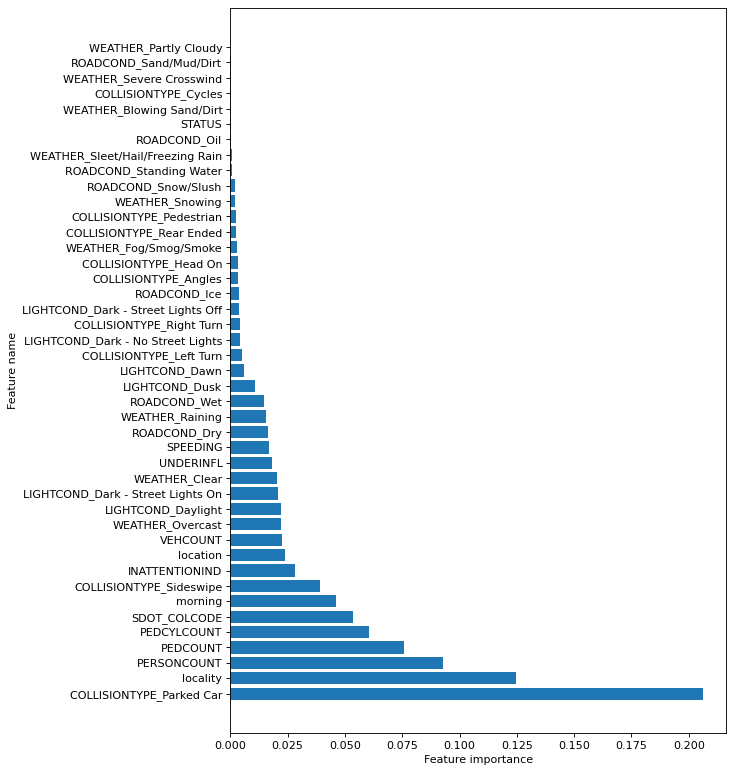

In [68]:
print('Features.size:', len(short_listed_opt))
plt.figure(figsize=(8, 12), dpi=80)
plot_feature_importances(feature_importances[indices], sorted_features)
plt.show()

#### List the sorted features according to their importances:

In [69]:
importances_df = pd.DataFrame(data=feature_importances[indices], index=sorted_features, columns=['Importance'])
#print('Feature importances: {}'.format(feature_importances[indices]))

num_features_selected = 30 # based on the importances plotted
#importances_df.iloc[:num_features_selected]

#### Note the number of features selected:

In [70]:
selected_features = importances_df.iloc[:num_features_selected]
selected_features.index

Index(['COLLISIONTYPE_Parked Car', 'locality', 'PERSONCOUNT', 'PEDCOUNT',
       'PEDCYLCOUNT', 'SDOT_COLCODE', 'morning', 'COLLISIONTYPE_Sideswipe',
       'INATTENTIONIND', 'location', 'VEHCOUNT', 'WEATHER_Overcast',
       'LIGHTCOND_Daylight', 'LIGHTCOND_Dark - Street Lights On',
       'WEATHER_Clear', 'UNDERINFL', 'SPEEDING', 'ROADCOND_Dry',
       'WEATHER_Raining', 'ROADCOND_Wet', 'LIGHTCOND_Dusk', 'LIGHTCOND_Dawn',
       'COLLISIONTYPE_Left Turn', 'LIGHTCOND_Dark - No Street Lights',
       'COLLISIONTYPE_Right Turn', 'LIGHTCOND_Dark - Street Lights Off',
       'ROADCOND_Ice', 'COLLISIONTYPE_Angles', 'COLLISIONTYPE_Head On',
       'WEATHER_Fog/Smog/Smoke'],
      dtype='object')

### Attempt dimentionality reduction using PCA:

In [71]:
n_components = 2 # keep numbers of features low or lower
pca = SparsePCA(n_components=n_components)
X_pca = pca.fit_transform(X)
X = X_pca # may comment this out if ...
X[0:5]

array([[-1.43980172, -4.07547717],
       [ 1.63966607,  0.42677844],
       [ 2.78268484, -2.78833877],
       [-2.44497544,  0.94456722],
       [-0.47763298, -0.09397115]])

#### Plot the outcome of dimensionality reduction

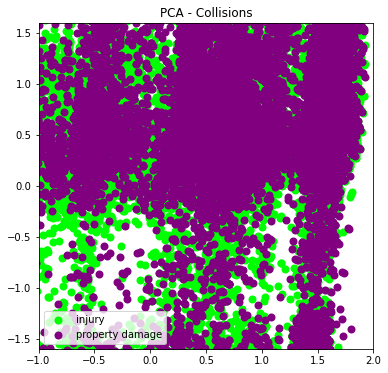

In [72]:
colors = ['lime', 'purple']
target_names = ['injury', 'property damage']
plt.figure(figsize=(6, 6))
#plot the top two latent features
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], color=color, lw=2, label=target_name)

plt.title('PCA - Collisions')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.axis([-1, 2, -1.6, 1.6])
plt.show()

# Classification

A training set is used to build a accurate model, based on a set of classifiers. A test set is used to evaluate the accuracy of classifiers. Thereafter, the best classifier model is selected.

The following candidate classifier algorithms are evaluated:
- K Nearest Neighbor(KNN) (*typically, simple and expected to do a good jobs*)
- Decision Tree (DT)
- Gradient Boosted Decision Trees (GBDT) (*using an ensemble of classifiers*)

### Prepare the Training and Test Sets

In [73]:
test_prop = 0.25 # proportion of data set reserved for evaluation or testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_prop, random_state=0)
print ('Train set (training models):', X_train.shape,  y_train.shape)
print ('Test set (evaluating models):', X_test.shape,  y_test.shape)

Train set (training models): (131403, 2) (131403,)
Test set (evaluating models): (43802, 2) (43802,)


### Set up how the models will be evaluated (using cross-validation):

For Evaluating the Models:<br/>
*First, review the list of possible evaluation scorers*

In [74]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

# K Nearest Neighbor (KNN)

The best accuracy was 0.7307657184603443 with k= 4


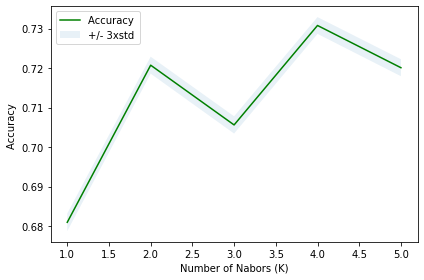

In [75]:
# Calculate the accuracy of KNN for different Ks
Ks = 6
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = np.mean(y_test == yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
print( "The best accuracy was", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
# Plot model accuracy for different number of Neighbors
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [76]:
# Finally, train Model using the best k
k = 4 # optimal k from above
knn_model = KNeighborsClassifier(n_neighbors = k)
knn_model

KNeighborsClassifier(n_neighbors=4)

In [77]:
# Evaluate model: accuracy is the default scoring metric
print('Cross-validation (accuracy)', cross_val_score(knn_model, X, y, cv=5))
# use AUC as scoring metric
print('Cross-validation (AUC)', np.average(cross_val_score(knn_model, X, y, cv=5, scoring = 'roc_auc')))
# use recall as scoring metric
print('Cross-validation (recall)', np.average(cross_val_score(knn_model, X, y, cv=5, scoring = 'recall')))
# use precision as scoring metric
print('Cross-validation (precision)', np.average(cross_val_score(knn_model, X, y, cv=5, scoring = 'precision_macro')))
# use f1 as scoring metric
print('Cross-validation (f1)', np.average(cross_val_score(knn_model, X, y, cv=5, scoring = 'f1_weighted')))

Cross-validation (accuracy) [0.73020176 0.73008761 0.72683428 0.73374048 0.73014469]
Cross-validation (AUC) 0.6993688146331705
Cross-validation (recall) 0.3148275857174402
Cross-validation (precision) 0.6744714064437822
Cross-validation (f1) 0.7011842859619299


# Decision Tree (DT)

The best accuracy was 0.7499429249805944 with max_depth= 5


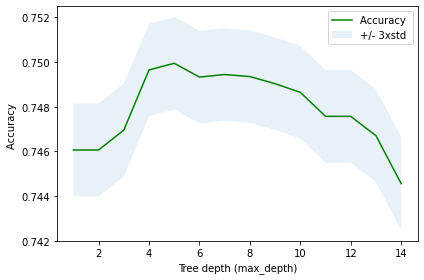

In [78]:
# Calculate the accuracy of tree classifier for different depths
tree_depths = 15
mean_acc = np.zeros((tree_depths-1))
std_acc = np.zeros((tree_depths-1))
for n in range(1,tree_depths):
    #Train Model and Predict
    tree_classifier = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    tree_classifier.fit(X_train,y_train)
    yhat=tree_classifier.predict(X_test)
    mean_acc[n-1] = np.mean(y_test == yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
print( "The best accuracy was", mean_acc.max(), "with max_depth=", mean_acc.argmax()+1) 
# Plot model accuracy for different tree depths
plt.plot(range(1,tree_depths),mean_acc,'g')
plt.fill_between(range(1,tree_depths),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Tree depth (max_depth)')
plt.tight_layout()
plt.show()

In [79]:
# Train Model and Predict
tree_depths = 5 # optimal depth from above
tree_model = DecisionTreeClassifier(criterion="entropy", max_depth = tree_depths)
tree_model

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [80]:
# Evaluate model: accuracy is the default scoring metric
print('Cross-validation (accuracy)', np.average(cross_val_score(tree_model, X, y, cv=5)))
# use AUC as scoring metric
print('Cross-validation (AUC)', np.average(cross_val_score(tree_model, X, y, cv=5, scoring = 'roc_auc')))
# use recall as scoring metric
print('Cross-validation (recall)', np.average(cross_val_score(tree_model, X, y, cv=5, scoring = 'recall')))
# use precision as scoring metric
print('Cross-validation (precision)', np.average(cross_val_score(tree_model, X, y, cv=5, scoring = 'precision_macro')))
# use f1 as scoring metric
print('Cross-validation (f1)', np.average(cross_val_score(tree_model, X, y, cv=5, scoring = 'f1_weighted')))

Cross-validation (accuracy) 0.7496190177220969
Cross-validation (AUC) 0.6936246003570281
Cross-validation (recall) 0.20692100176507133
Cross-validation (precision) 0.7870853164738971
Cross-validation (f1) 0.6917709784678208


# Gradient Boosted Decision Trees (GBDT)

The best accuracy was 0.7511985754075157 with n_estimators = 75


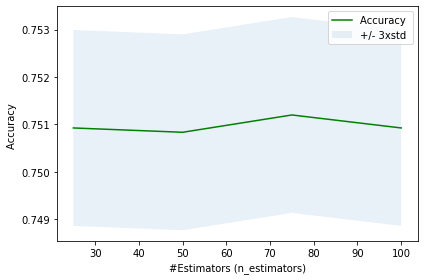

In [81]:
# Calculate the accuracy of SVM for different C, and degree, and gamma
start = 25
stop = 101
step = 25 # based on the setup above
n_estimators = range(start, stop, step) # e.g. [25, 50, 75, 100]
max_depth = 5 # leveraging from DT analysis above
learning_rate = 0.15
random_state = 0 # ensure repeatable
mean_acc = np.zeros(len(n_estimators))
std_acc = np.zeros(len(n_estimators))
for c, this_estimators in enumerate(n_estimators):
    gb_classifier = GradientBoostingClassifier(n_estimators=this_estimators, max_depth=max_depth, \
                                                 learning_rate=learning_rate, random_state=random_state)
    gb_classifier.fit(X_train, y_train)
    yhat = gb_classifier.predict(X_test)
    mean_acc[c] = np.mean(y_test == yhat)
    std_acc[c] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print( "The best accuracy was", mean_acc.max(), "with n_estimators =", n_estimators[mean_acc.argmax()]) 
# Plot model accuracy for different n_estimators
plt.plot(range(start, stop, step), mean_acc,'g')
plt.fill_between(range(start, stop, step), mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('#Estimators (n_estimators)')
plt.tight_layout()
plt.show()

In [82]:
# Finally, train Model using the best parameters
n_estimators = 75
max_depth = 5 # leveraging from DT analysis above
learning_rate = 0.15
random_state = 0 # ensure repeatable
gbdt_model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, \
                                                 learning_rate=learning_rate, random_state=random_state)
gbdt_model

GradientBoostingClassifier(learning_rate=0.15, max_depth=5, n_estimators=75,
                           random_state=0)

In [ ]:
# Evaluate model: accuracy is the default scoring metric
print('Cross-validation (accuracy)', np.average(cross_val_score(gbdt_model, X, y, cv=2)))
# use AUC as scoring metric
print('Cross-validation (AUC)', np.average(cross_val_score(gbdt_model, X, y, cv=2, scoring = 'roc_auc')))
# use recall as scoring metric
print('Cross-validation (recall)', np.average(cross_val_score(gbdt_model, X, y, cv=2, scoring = 'recall')))
# use precision as scoring metric
print('Cross-validation (precision)', np.average(cross_val_score(gbdt_model, X, y, cv=2, scoring = 'precision_macro')))
# use f1 as scoring metric
print('Cross-validation (f1)', np.average(cross_val_score(gbdt_model, X, y, cv=2, scoring = 'f1_weighted')))

Cross-validation (accuracy) 0.7509317692212801


# Final Model Testing
Test the classifiers using the final data set set aside earlier.

In [ ]:
# Evaluate model: accuracy is the default scoring metric
print('Cross-validation (accuracy)', np.average(cross_val_score(knn_model, X_whole_test, y_whole_test, cv=5)))
# use AUC as scoring metric
print('Cross-validation (AUC)', np.average(cross_val_score(knn_model, X_whole_test, y_whole_test, cv=5, scoring = 'roc_auc')))
# use recall as scoring metric
print('Cross-validation (recall)', np.average(cross_val_score(knn_model, X_whole_test, y_whole_test, cv=5, scoring = 'recall')))
# use precision as scoring metric
print('Cross-validation (precision)', np.average(cross_val_score(knn_model, X_whole_test, y_whole_test, cv=5, scoring = 'precision_macro')))
# use f1 as scoring metric
print('Cross-validation (f1)', np.average(cross_val_score(knn_model, X_whole_test, y_whole_test, cv=5, scoring = 'f1_weighted')))

In [ ]:
# Evaluate model: accuracy is the default scoring metric
print('Cross-validation (accuracy)', np.average(cross_val_score(tree_model, X_whole_test, y_whole_test, cv=5)))
# use AUC as scoring metric
print('Cross-validation (AUC)', np.average(cross_val_score(tree_model, X_whole_test, y_whole_test, cv=5, scoring = 'roc_auc')))
# use recall as scoring metric
print('Cross-validation (recall)', np.average(cross_val_score(tree_model, X_whole_test, y_whole_test, cv=5, scoring = 'recall')))
# use precision as scoring metric
print('Cross-validation (precision)', np.average(cross_val_score(tree_model, X_whole_test, y_whole_test, cv=5, scoring = 'precision_macro')))
# use f1 as scoring metric
print('Cross-validation (f1)', np.average(cross_val_score(tree_model, X_whole_test, y_whole_test, cv=5, scoring = 'f1_weighted')))

In [ ]:
# Evaluate model: accuracy is the default scoring metric
print('Cross-validation (accuracy)', np.average(cross_val_score(gbdt_model, X_whole_test, y_whole_test, cv=2)))
# use AUC as scoring metric
print('Cross-validation (AUC)', np.average(cross_val_score(gbdt_model, X_whole_test, y_whole_test, cv=2, scoring = 'roc_auc')))
# use recall as scoring metric
print('Cross-validation (recall)', np.average(cross_val_score(gbdt_model, X_whole_test, y_whole_test, cv=2, scoring = 'recall')))
# use precision as scoring metric
print('Cross-validation (precision)', np.average(cross_val_score(gbdt_model, X_whole_test, y_whole_test, cv=2, scoring = 'precision_macro')))
# use f1 as scoring metric
print('Cross-validation (f1)', np.average(cross_val_score(gbdt_model, X_whole_test, y_whole_test, cv=2, scoring = 'f1_weighted')))